# **Combine training, validation data with satellite data**

This notebook is used to extract the corresponding satellite band values of training and validation data. Some indices such as NDVI, NDBI and NDWI are also created using the extracted band values.

In [1]:
pip install rioxarray pystac_client planetary_computer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 54.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd
from shapely.geometry import Point

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

In [3]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("/kaggle/input/uncorrupted/Training_data_uhi_index_2025-02-18.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


In [4]:
ground_df.shape

(11229, 4)

## Sentinel 2

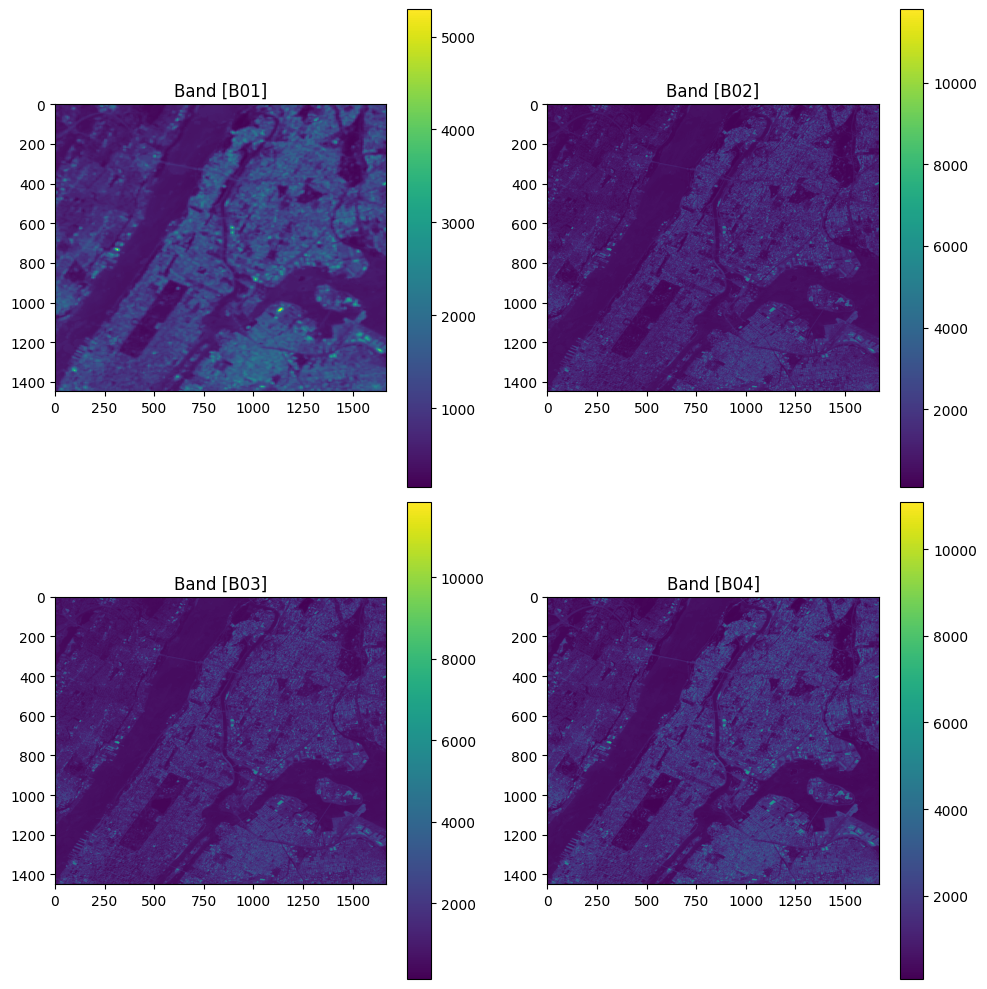

In [5]:
# Open the Sentinel 2 GeoTIFF file
tiff_path = "/kaggle/input/train-data/S2.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B02]
    band3 = src1.read(3)  # Band [B03]
    band4 = src1.read(4)  # Band [B04]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])


# Plot the second band (B02)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B02]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B03)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B03]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B04)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B04]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()

A buffer of radius 400m is created for each location. Then the mean value of each band is calculated. This helps to remove spatial autocorrelation of the data.

In [6]:
def map_satellite_data_S2(tiff_path, csv_path, buffer_distance=400):
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs
    
    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Define a projected CRS for New York City (UTM Zone 18N)
    projected_crs = CRS.from_epsg(32618)  # EPSG:32618 is UTM Zone 18N
    
    # Convert lat/long to the GeoTIFF's CRS
    transformer = Transformer.from_crs("EPSG:4326", tiff_crs, always_xy=True)
    
    # Lists to store the band values
    B01_values = []
    B02_values = []
    B03_values = []
    B04_values = []
    B05_values = []
    B06_values = []
    B07_values = []
    B08_values = []
    B8A_values = []
    B11_values = []
    B12_values = []
    
    # Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        try:
            # Convert lat, lon to the target CRS (note x=lon, y=lat)
            x, y = transformer.transform(lon, lat)
            
            # Create a GeoDataFrame with the point in the raster's CRS
            gdf = gpd.GeoDataFrame(geometry=[Point(x, y)], crs=tiff_crs)

            # Reproject to a projected CRS (meters) before buffering
            gdf = gdf.to_crs(projected_crs)

            # Apply the buffer in meters
            gdf["geometry"] = gdf.geometry.buffer(buffer_distance)

            # Convert back to the raster's CRS
            gdf = gdf.to_crs(tiff_crs)

            # Clip the raster using the buffered geometry
            masked_data = data.rio.clip(gdf.geometry, all_touched=True, drop=True)
            
            # Calculate the mean value for each band within the buffer (ignoring NaN values)
            B01_values.append(np.nanmean(masked_data.sel(band=1).values))
            B02_values.append(np.nanmean(masked_data.sel(band=2).values))
            B03_values.append(np.nanmean(masked_data.sel(band=3).values))
            B04_values.append(np.nanmean(masked_data.sel(band=4).values))
            B05_values.append(np.nanmean(masked_data.sel(band=5).values))
            B06_values.append(np.nanmean(masked_data.sel(band=6).values))
            B07_values.append(np.nanmean(masked_data.sel(band=7).values))
            B08_values.append(np.nanmean(masked_data.sel(band=8).values))
            B8A_values.append(np.nanmean(masked_data.sel(band=9).values))
            B11_values.append(np.nanmean(masked_data.sel(band=10).values))
            B12_values.append(np.nanmean(masked_data.sel(band=11).values))
            
        except Exception as e:
            # If there's an error (e.g., point outside raster bounds), append NaN
            print(f"Error processing point ({lat}, {lon}): {e}")
            B01_values.append(np.nan)
            B02_values.append(np.nan)
            B03_values.append(np.nan)
            B04_values.append(np.nan)
            B05_values.append(np.nan)
            B06_values.append(np.nan)
            B07_values.append(np.nan)
            B08_values.append(np.nan)
            B8A_values.append(np.nan)
            B11_values.append(np.nan)
            B12_values.append(np.nan)
    
    # Create a DataFrame to store the band values
    result_df = pd.DataFrame()
    result_df['B01'] = B01_values
    result_df['B02'] = B02_values
    result_df['B03'] = B03_values
    result_df['B04'] = B04_values
    result_df['B05'] = B05_values
    result_df['B06'] = B06_values
    result_df['B07'] = B07_values
    result_df['B08'] = B08_values
    result_df['B8A'] = B8A_values
    result_df['B11'] = B11_values
    result_df['B12'] = B12_values
    
    return result_df

In [7]:
# Mapping satellite data with training data.
S2_data = map_satellite_data_S2('/kaggle/input/train-data/S2.tiff', '/kaggle/input/uncorrupted/Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [43:27<00:00,  4.31it/s]


In [8]:
S2_data.describe()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000
mean,1113.525991,1218.880316,1372.376123,1429.011493,1658.451804,2114.714573,2300.108929,2281.303312,2361.817821,2199.407206,1861.798604
std,212.602108,229.349335,230.220267,281.953283,256.796143,241.970557,312.709346,326.712153,346.108503,271.241033,320.238982
min,387.783895,425.670425,544.584627,398.805857,672.854990,1237.573519,1300.801082,1251.642387,1297.830627,1150.859693,711.011272
25%,1008.883292,1105.675004,1248.877981,1291.068723,1511.083590,1991.083382,2137.151449,2110.985808,2176.686768,2031.068824,1682.465691
50%,1130.334992,1238.660678,1391.309851,1453.669786,1691.021083,2169.611306,2322.795757,2296.749269,2374.687920,2263.113254,1911.757141
75%,1264.002924,1379.135187,1540.824140,1629.204010,1850.702924,2264.408405,2446.379593,2427.487202,2512.923460,2390.051185,2093.770108
max,1618.629061,1768.004390,1929.990489,2051.577846,2252.441323,2701.651741,3351.871671,3416.290167,3601.332309,2756.359731,2568.723124


In [9]:
S2_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,1036.934045,1144.664522,1325.140099,1373.032466,1644.462855,2236.069319,2455.611436,2466.095934,2552.886809,2305.273326,1920.796870
1,1036.971023,1144.358700,1325.462754,1372.924045,1645.394702,2238.420167,2458.660325,2469.320650,2556.644227,2309.511781,1923.721499
2,1038.801550,1145.059082,1327.088037,1374.093302,1649.179292,2243.552647,2464.690699,2474.530126,2563.074729,2316.142001,1928.230915
3,1040.573078,1146.855305,1329.966823,1376.344928,1653.159602,2249.616779,2471.592663,2482.465069,2571.105817,2323.466530,1933.006431
4,1041.853259,1149.656095,1333.705642,1380.476761,1657.821397,2255.589594,2477.846536,2488.394475,2578.136510,2331.205495,1938.843467


In [10]:
S2_data

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,1036.934045,1144.664522,1325.140099,1373.032466,1644.462855,2236.069319,2455.611436,2466.095934,2552.886809,2305.273326,1920.796870
1,1036.971023,1144.358700,1325.462754,1372.924045,1645.394702,2238.420167,2458.660325,2469.320650,2556.644227,2309.511781,1923.721499
2,1038.801550,1145.059082,1327.088037,1374.093302,1649.179292,2243.552647,2464.690699,2474.530126,2563.074729,2316.142001,1928.230915
3,1040.573078,1146.855305,1329.966823,1376.344928,1653.159602,2249.616779,2471.592663,2482.465069,2571.105817,2323.466530,1933.006431
4,1041.853259,1149.656095,1333.705642,1380.476761,1657.821397,2255.589594,2477.846536,2488.394475,2578.136510,2331.205495,1938.843467
...,...,...,...,...,...,...,...,...,...,...,...
11224,505.685643,572.625055,772.841065,650.941461,1053.070247,2412.781062,2945.695010,3003.498756,3164.168008,1954.692083,1197.219230
11225,506.378600,573.498319,773.090922,651.615261,1052.131706,2406.308581,2937.011548,2994.413975,3154.576962,1951.042245,1196.335477
11226,506.808327,573.802776,772.254054,650.838276,1049.258291,2394.775749,2921.794449,2978.314390,3137.486194,1943.507378,1193.436669
11227,506.673153,574.064228,772.491587,651.082663,1048.719093,2392.514411,2918.759766,2975.127140,3134.157718,1941.849744,1192.670373


In [11]:
# Calculate NDVI (Normalized Difference Vegetation Index)
# NDVI = (NIR - RED) / (NIR + RED)
S2_data['NDVI'] = (S2_data['B08'] - S2_data['B04']) / (S2_data['B08'] + S2_data['B04'])
S2_data['NDVI'] = S2_data['NDVI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDBI (Normalized Difference Built-Up Index)
# NDBI = (SWIR - NIR) / (SWIR + NIR)
S2_data['NDBI'] = (S2_data['B11'] - S2_data['B08']) / (S2_data['B11'] + S2_data['B08'])
S2_data['NDBI'] = S2_data['NDBI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDWI (Normalized Difference Water Index)
# NDWI = (Green - NIR) / (Green + NIR)
S2_data['NDWI'] = (S2_data['B03'] - S2_data['B08']) / (S2_data['B03'] + S2_data['B08'])
S2_data['NDWI'] = S2_data['NDWI'].replace([np.inf, -np.inf], np.nan)

In [12]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [13]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,S2_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1036.934045,1144.664522,1325.140099,1373.032466,1644.462855,2236.069319,2455.611436,2466.095934,2552.886809,2305.273326,1920.796870,0.284717,-0.033706,-0.300946
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,1036.971023,1144.358700,1325.462754,1372.924045,1645.394702,2238.420167,2458.660325,2469.320650,2556.644227,2309.511781,1923.721499,0.285353,-0.033441,-0.301429
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1038.801550,1145.059082,1327.088037,1374.093302,1649.179292,2243.552647,2464.690699,2474.530126,2563.074729,2316.142001,1928.230915,0.285930,-0.033062,-0.301830
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1040.573078,1146.855305,1329.966823,1376.344928,1653.159602,2249.616779,2471.592663,2482.465069,2571.105817,2323.466530,1933.006431,0.286648,-0.033084,-0.302300
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1041.853259,1149.656095,1333.705642,1380.476761,1657.821397,2255.589594,2477.846536,2488.394475,2578.136510,2331.205495,1938.843467,0.286367,-0.032615,-0.302108


In [14]:
uhi_data

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1036.934045,1144.664522,1325.140099,1373.032466,1644.462855,2236.069319,2455.611436,2466.095934,2552.886809,2305.273326,1920.796870,0.284717,-0.033706,-0.300946
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,1036.971023,1144.358700,1325.462754,1372.924045,1645.394702,2238.420167,2458.660325,2469.320650,2556.644227,2309.511781,1923.721499,0.285353,-0.033441,-0.301429
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1038.801550,1145.059082,1327.088037,1374.093302,1649.179292,2243.552647,2464.690699,2474.530126,2563.074729,2316.142001,1928.230915,0.285930,-0.033062,-0.301830
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1040.573078,1146.855305,1329.966823,1376.344928,1653.159602,2249.616779,2471.592663,2482.465069,2571.105817,2323.466530,1933.006431,0.286648,-0.033084,-0.302300
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1041.853259,1149.656095,1333.705642,1380.476761,1657.821397,2255.589594,2477.846536,2488.394475,2578.136510,2331.205495,1938.843467,0.286367,-0.032615,-0.302108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,505.685643,572.625055,772.841065,650.941461,1053.070247,2412.781062,2945.695010,3003.498756,3164.168008,1954.692083,1197.219230,0.643753,-0.211530,-0.590693
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,506.378600,573.498319,773.090922,651.615261,1052.131706,2406.308581,2937.011548,2994.413975,3154.576962,1951.042245,1196.335477,0.642562,-0.210976,-0.589601
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,506.808327,573.802776,772.254054,650.838276,1049.258291,2394.775749,2921.794449,2978.314390,3137.486194,1943.507378,1193.436669,0.641328,-0.210249,-0.588194
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,506.673153,574.064228,772.491587,651.082663,1048.719093,2392.514411,2918.759766,2975.127140,3134.157718,1941.849744,1192.670373,0.640902,-0.210145,-0.587743


In [15]:
uhi_data.shape

(11229, 18)

## LandSAT (for Land Surface Temperature)

Similar to Sentinel-2, buffer distance of 400m is used.

In [16]:
def map_satellite_data_LST(tiff_path, csv_path, buffer_distance=400):
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs
    
    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values
    
    # Convert lat/long to the GeoTIFF's CRS
    transformer = Transformer.from_crs("EPSG:4326", tiff_crs, always_xy=True)
    
    # List to store the LST values
    LST_values = []

    # Define a projected CRS for New York City (UTM Zone 18N)
    projected_crs = CRS.from_epsg(32618)  # EPSG:32618 is UTM Zone 18N
    
    # Iterate over the latitudes and longitudes, and extract the corresponding LST values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        try:
            # Convert lat, lon to the target CRS (note x=lon, y=lat)
            x, y = transformer.transform(lon, lat)
            
            # Create a GeoDataFrame with the point in the raster's CRS
            gdf = gpd.GeoDataFrame(geometry=[Point(x, y)], crs=tiff_crs)

            # Reproject to a projected CRS (meters) before buffering
            gdf = gdf.to_crs(projected_crs)

            # Apply the buffer in meters
            gdf["geometry"] = gdf.geometry.buffer(buffer_distance)

            # Convert back to the raster's CRS
            gdf = gdf.to_crs(tiff_crs)

            # Clip the raster using the buffered geometry
            masked_data = data.rio.clip(gdf.geometry, all_touched=True, drop=True)
            
            # Calculate the mean LST value within the buffer (ignoring NaN values)
            LST_values.append(np.nanmean(masked_data.sel(band=1).values))
            
        except Exception as e:
            # If there's an error (e.g., point outside raster bounds), append NaN
            print(f"Error processing point ({lat}, {lon}): {e}")
            LST_values.append(np.nan)
    
    # Create a DataFrame to store the LST values
    result_df = pd.DataFrame()
    result_df['LST'] = LST_values
    
    return result_df

In [17]:
# Mapping satellite data with training data.
LST_data = map_satellite_data_LST('/kaggle/input/train-data/Landsat_LST.tiff', '/kaggle/input/uncorrupted/Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [04:07<00:00, 45.30it/s]


In [18]:
LST_data

,LST
0,37.143640
1,37.147602
2,37.169067
3,37.180983
4,37.173729
...,...
11224,31.250745
11225,31.230093
11226,31.220690
11227,31.205963


In [19]:
final_data = combine_two_datasets(uhi_data,LST_data)

In [20]:
final_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI,LST
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1036.934045,1144.664522,1325.140099,1373.032466,1644.462855,2236.069319,2455.611436,2466.095934,2552.886809,2305.273326,1920.796870,0.284717,-0.033706,-0.300946,37.143640
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,1036.971023,1144.358700,1325.462754,1372.924045,1645.394702,2238.420167,2458.660325,2469.320650,2556.644227,2309.511781,1923.721499,0.285353,-0.033441,-0.301429,37.147602
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1038.801550,1145.059082,1327.088037,1374.093302,1649.179292,2243.552647,2464.690699,2474.530126,2563.074729,2316.142001,1928.230915,0.285930,-0.033062,-0.301830,37.169067
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1040.573078,1146.855305,1329.966823,1376.344928,1653.159602,2249.616779,2471.592663,2482.465069,2571.105817,2323.466530,1933.006431,0.286648,-0.033084,-0.302300,37.180983
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1041.853259,1149.656095,1333.705642,1380.476761,1657.821397,2255.589594,2477.846536,2488.394475,2578.136510,2331.205495,1938.843467,0.286367,-0.032615,-0.302108,37.173729


In [21]:
final_data.shape

(11229, 19)

In [22]:
final_data

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI,LST
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1036.934045,1144.664522,1325.140099,1373.032466,1644.462855,2236.069319,2455.611436,2466.095934,2552.886809,2305.273326,1920.796870,0.284717,-0.033706,-0.300946,37.143640
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,1036.971023,1144.358700,1325.462754,1372.924045,1645.394702,2238.420167,2458.660325,2469.320650,2556.644227,2309.511781,1923.721499,0.285353,-0.033441,-0.301429,37.147602
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1038.801550,1145.059082,1327.088037,1374.093302,1649.179292,2243.552647,2464.690699,2474.530126,2563.074729,2316.142001,1928.230915,0.285930,-0.033062,-0.301830,37.169067
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1040.573078,1146.855305,1329.966823,1376.344928,1653.159602,2249.616779,2471.592663,2482.465069,2571.105817,2323.466530,1933.006431,0.286648,-0.033084,-0.302300,37.180983
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1041.853259,1149.656095,1333.705642,1380.476761,1657.821397,2255.589594,2477.846536,2488.394475,2578.136510,2331.205495,1938.843467,0.286367,-0.032615,-0.302108,37.173729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,505.685643,572.625055,772.841065,650.941461,1053.070247,2412.781062,2945.695010,3003.498756,3164.168008,1954.692083,1197.219230,0.643753,-0.211530,-0.590693,31.250745
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,506.378600,573.498319,773.090922,651.615261,1052.131706,2406.308581,2937.011548,2994.413975,3154.576962,1951.042245,1196.335477,0.642562,-0.210976,-0.589601,31.230093
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,506.808327,573.802776,772.254054,650.838276,1049.258291,2394.775749,2921.794449,2978.314390,3137.486194,1943.507378,1193.436669,0.641328,-0.210249,-0.588194,31.220690
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,506.673153,574.064228,772.491587,651.082663,1048.719093,2392.514411,2918.759766,2975.127140,3134.157718,1941.849744,1192.670373,0.640902,-0.210145,-0.587743,31.205963


In [23]:
output_csv_file = 'training_data_with_satellite.csv'

# Save the DataFrame to CSV
final_data.to_csv(output_csv_file, index=False)

print(f"Data has been successfully saved to {output_csv_file}.")

Data has been successfully saved to training_data_with_satellite.csv.


## Repeat for validation data

In [24]:
# Load the validation data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("/kaggle/input/validation-dataset/Submission_template_UHI2025-v2.csv")
ground_df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [25]:
# Mapping satellite data with validation data.
S2_data = map_satellite_data_S2('/kaggle/input/train-data/S2.tiff', '/kaggle/input/validation-dataset/Submission_template_UHI2025-v2.csv')

Mapping values: 100%|██████████| 1040/1040 [04:00<00:00,  4.32it/s]


In [26]:
S2_data.describe()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
count,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000
mean,1116.356812,1221.989267,1374.882353,1433.592216,1660.291837,2104.120425,2284.875506,2265.436453,2344.942502,2196.144010,1864.763841
std,206.133696,222.937807,225.101617,274.803421,253.508040,239.746131,304.478722,317.073873,335.255026,274.220023,318.612747
min,407.868771,428.827415,550.323250,405.309221,685.648400,1245.059985,1306.655551,1257.690361,1302.462191,1149.277607,729.005992
25%,1021.071295,1116.134236,1259.837407,1308.862710,1525.207876,1975.995864,2112.102293,2077.313852,2155.119107,2029.493432,1696.938964
50%,1129.187098,1237.697148,1395.704377,1453.684703,1694.331075,2166.568108,2316.588545,2292.349070,2370.259610,2258.874104,1906.822101
75%,1267.596644,1382.611769,1543.766024,1632.548753,1853.322993,2258.532049,2441.608150,2422.310050,2503.534671,2392.356403,2090.805275
max,1532.894675,1678.401258,1812.974400,1944.131929,2128.255487,2634.991228,3326.358543,3382.564804,3554.191340,2729.049305,2541.975428


In [27]:
# Calculate NDVI (Normalized Difference Vegetation Index)
# NDVI = (NIR - RED) / (NIR + RED)
S2_data['NDVI'] = (S2_data['B08'] - S2_data['B04']) / (S2_data['B08'] + S2_data['B04'])
S2_data['NDVI'] = S2_data['NDVI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDBI (Normalized Difference Built-Up Index)
# NDBI = (SWIR - NIR) / (SWIR + NIR)
S2_data['NDBI'] = (S2_data['B11'] - S2_data['B08']) / (S2_data['B11'] + S2_data['B08'])
S2_data['NDBI'] = S2_data['NDBI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDWI (Normalized Difference Water Index)
# NDWI = (Green - NIR) / (Green + NIR)
S2_data['NDWI'] = (S2_data['B03'] - S2_data['B08']) / (S2_data['B03'] + S2_data['B08'])
S2_data['NDWI'] = S2_data['NDWI'].replace([np.inf, -np.inf], np.nan)

In [28]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,S2_data)
uhi_data.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI
0,-73.971665,40.788763,NaN,1109.576929,1229.599619,1355.112575,1425.643830,1626.311228,2012.087688,2174.133802,2140.140682,2224.516030,2146.136730,1826.886547,0.200376,0.001399,-0.224598
1,-73.971928,40.788875,NaN,1115.170029,1239.381140,1365.236988,1438.272807,1636.686696,2007.709649,2165.796345,2131.762135,2214.216520,2150.349123,1836.398977,0.194253,0.004341,-0.219195
2,-73.967080,40.789080,NaN,795.622951,881.664959,1005.529128,972.993999,1216.328747,1958.375732,2245.151347,2245.597043,2336.408811,1815.682231,1377.212968,0.395391,-0.105857,-0.381427
3,-73.972550,40.789082,NaN,1120.069213,1239.884109,1364.432543,1438.773632,1638.771291,2003.329968,2158.598186,2126.738806,2206.887035,2147.318115,1831.670618,0.192950,0.004815,-0.218353
4,-73.969697,40.787953,NaN,951.219441,1046.451471,1173.158542,1190.453960,1423.341238,2052.694042,2301.973503,2288.260430,2383.179476,2009.478846,1600.800322,0.315578,-0.064867,-0.322152


In [29]:
# Mapping satellite data with validation data.
LST_data = map_satellite_data_LST('/kaggle/input/train-data/Landsat_LST.tiff', '/kaggle/input/validation-dataset/Submission_template_UHI2025-v2.csv')

Mapping values: 100%|██████████| 1040/1040 [00:23<00:00, 44.91it/s]


In [30]:
LST_data

,LST
0,36.637337
1,36.703919
2,33.485227
3,36.817434
4,35.072928
...,...
1035,38.301057
1036,34.295485
1037,35.318016
1038,39.275001


In [31]:
final_data = combine_two_datasets(uhi_data,LST_data)

In [32]:
final_data.shape

(1040, 18)

In [33]:
final_data

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI,LST
0,-73.971665,40.788763,NaN,1109.576929,1229.599619,1355.112575,1425.643830,1626.311228,2012.087688,2174.133802,2140.140682,2224.516030,2146.136730,1826.886547,0.200376,0.001399,-0.224598,36.637337
1,-73.971928,40.788875,NaN,1115.170029,1239.381140,1365.236988,1438.272807,1636.686696,2007.709649,2165.796345,2131.762135,2214.216520,2150.349123,1836.398977,0.194253,0.004341,-0.219195,36.703919
2,-73.967080,40.789080,NaN,795.622951,881.664959,1005.529128,972.993999,1216.328747,1958.375732,2245.151347,2245.597043,2336.408811,1815.682231,1377.212968,0.395391,-0.105857,-0.381427,33.485227
3,-73.972550,40.789082,NaN,1120.069213,1239.884109,1364.432543,1438.773632,1638.771291,2003.329968,2158.598186,2126.738806,2206.887035,2147.318115,1831.670618,0.192950,0.004815,-0.218353,36.817434
4,-73.969697,40.787953,NaN,951.219441,1046.451471,1173.158542,1190.453960,1423.341238,2052.694042,2301.973503,2288.260430,2383.179476,2009.478846,1600.800322,0.315578,-0.064867,-0.322152,35.072928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,-73.919388,40.813803,NaN,1272.300979,1380.380646,1541.268382,1620.022073,1853.269405,2235.326560,2378.083321,2363.448765,2432.748867,2365.825903,2075.849876,0.186628,0.000503,-0.210561,38.301057
1036,-73.931033,40.833178,NaN,1050.194156,1142.677283,1291.879766,1340.141563,1528.703871,1855.685756,2000.745215,1953.988751,2021.545069,1907.110299,1661.925493,0.186346,-0.012141,-0.203985,34.295485
1037,-73.934647,40.854542,NaN,1346.891111,1432.297037,1573.579915,1653.583418,1887.427091,2363.367392,2558.945555,2509.849949,2613.213108,2533.462122,2225.875931,0.205664,0.004682,-0.229285,35.318016
1038,-73.917223,40.815413,NaN,1396.821037,1527.630679,1680.757341,1794.624105,1991.946530,2207.874507,2307.917458,2286.222936,2350.156465,2484.799854,2242.893937,0.120465,0.041621,-0.152626,39.275001


In [34]:
output_csv_file = 'validation_data_with_satellite.csv'

# Save the DataFrame to CSV
final_data.to_csv(output_csv_file, index=False)

print(f"Data has been successfully saved to {output_csv_file}.")

Data has been successfully saved to validation_data_with_satellite.csv.
